In [17]:
import pandas as pd
import numpy as np
import pickle
import scipy.interpolate as interp
from scipy.spatial import distance_matrix
import scipy.io
from ripser import ripser, plot_dgms
import os
import struct
import matplotlib.pyplot as plt

In [2]:
path = '/home/robert/forex'
filename = path + '/data/currency/forex.pkl'
pkl_file = open(filename, 'rb')
data = pickle.load(pkl_file)
pkl_file.close()

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1482097 entries, 2007-01-01 20:00:00 to 2010-12-31 14:59:00
Data columns (total 16 columns):
USDJPY_M1_2009    343456 non-null float32
USDCAD_M1_2010    325765 non-null float32
EURUSD_M1_2010    352320 non-null float32
USDCAD_M1_2007    246689 non-null float32
USDCAD_M1_2008    276953 non-null float32
USDJPY_M1_2010    328836 non-null float32
GBPUSD_M1_2008    332167 non-null float32
EURUSD_M1_2009    355880 non-null float32
GBPUSD_M1_2009    354178 non-null float32
USDJPY_M1_2008    348226 non-null float32
USDJPY_M1_2007    322788 non-null float32
EURUSD_M1_2008    347355 non-null float32
EURUSD_M1_2007    299782 non-null float32
GBPUSD_M1_2010    348663 non-null float32
USDCAD_M1_2009    313683 non-null float32
GBPUSD_M1_2007    306750 non-null float32
dtypes: float32(16)
memory usage: 101.8 MB


In [4]:
# Fixes missing values. I'll probably do mean interpolation eventually, but not yet
def fixna(ts):
    return ts[~np.isnan(ts)]

In [5]:
def getSlidingWindow(x, dim, Tau, dT):
    '''
    This function takes time series x (without time-part)
    and returns a massive X, which has sliding windows as columns
    dim=3, Tau=5, dT=2 on range() object yields:
    [0, 5, 10]
    [2, 7, 12]
    [4, 11, 14] etc.
    '''
    N = len(x)
    NWindows = int(np.floor((N-dim*Tau)/dT)) # The number of windows
    if NWindows <= 0:
        print("Error: Tau too large for signal extent")
        return np.zeros((3, dim))
    X = np.zeros((NWindows, dim)) # Create a 2D array which will store all windows
    idx = np.arange(N)
    for i in range(NWindows):
        # Figure out the indices of the samples in this window
        idxx = dT*i + Tau*np.arange(dim)
        start = int(np.floor(idxx[0]))
        end = int(np.ceil(idxx[-1]))+2
        if end > len(x):
            X = X[0:i, :]
            break
        # Do spline interpolation to fill in this window, and place
        # it in the resulting array
        X[i, :] = x[idxx] #interp.spline(idx[start:end+1], x[start:end+1], idxx)
    return X

In [36]:
# This function takes in a large time series along with index of window start, length of window
# returns +1 for increase one day after end of series, -1 for decrease or level values, along with window
# return None for end of December
def classify(timeseries, index, sectionlength=1440):
    daylength = 1440
    dim = 4
    Tau = 15
    dT = 4
    if len(timeseries) < index + sectionlength + daylength:
        return 0, None
    section = timeseries.iloc[index:index+sectionlength]
    sectionendval = section.iloc[-1]
    futureval = timeseries.iloc[index+sectionlength+daylength]
    increase = futureval - sectionendval
    slidingwindow = getSlidingWindow(section.values, dim, Tau, dT)
    if increase > 0:
        return 1, slidingwindow
    else:
        return -1, slidingwindow

In [37]:
sectionlength = 1440
ts = data['EURUSD_M1_2009']
cleants = fixna(ts)
window = []
for i in range(0, len(cleants)-sectionlength, sectionlength):
    window.append(classify(cleants, i))

In [40]:
window[1][1].shape

(345, 4)

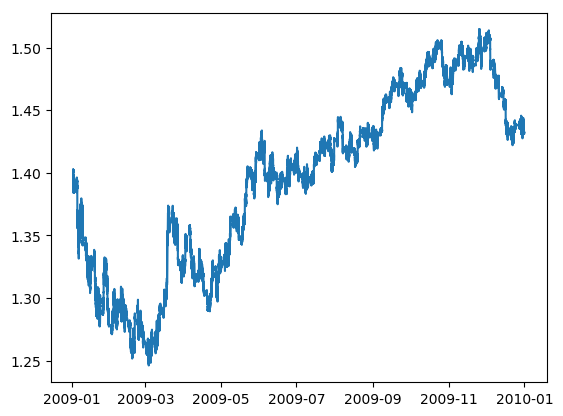

In [31]:
plt.plot(data['EURUSD_M1_2009'])

In [6]:
temp = data['USDJPY_M1_2007'].iloc[1000:1000+1440].values
temp = fixna(temp)

In [7]:
window = getSlidingWindow(temp, 4, 15, 4)
dist_mat = distance_matrix(window, window)

In [12]:
filtration = ripser(window)['dgms']

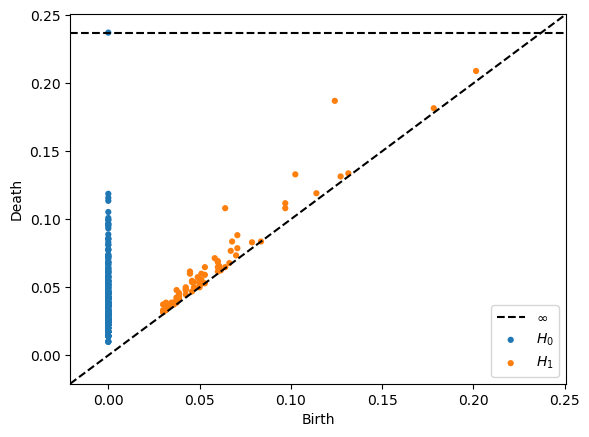

In [13]:
plot_dgms(filtration)

In [14]:
filtration

[array([[0.        , 0.00999451],
        [0.        , 0.01000214],
        [0.        , 0.01000214],
        [0.        , 0.01000214],
        [0.        , 0.01413976],
        [0.        , 0.01413976],
        [0.        , 0.01413976],
        [0.        , 0.01413976],
        [0.        , 0.01413976],
        [0.        , 0.01413976],
        [0.        , 0.01414516],
        [0.        , 0.01414516],
        [0.        , 0.01414516],
        [0.        , 0.01414516],
        [0.        , 0.01414516],
        [0.        , 0.0173154 ],
        [0.        , 0.0173154 ],
        [0.        , 0.0173198 ],
        [0.        , 0.0173198 ],
        [0.        , 0.0173198 ],
        [0.        , 0.0173198 ],
        [0.        , 0.0173198 ],
        [0.        , 0.01732421],
        [0.        , 0.01732421],
        [0.        , 0.01732421],
        [0.        , 0.01999664],
        [0.        , 0.01999664],
        [0.        , 0.01999664],
        [0.        , 0.01999664],
        [0.   

In [10]:
import matlab.engine
eng = matlab.engine.start_matlab()
%timeit eng.save_distance_matrix(matlab.double(dist_mat.tolist()), './temp', nargout=0)
eng.quit()

447 ms ± 12.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit os.system('dipha --upper_dim 2 temp out')

31.4 s ± 8.39 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# Look into making it sparse